# Allocation Strategy Analysis

Use this notebook to run allocation strategies on available equity data.

Download historical stock prices from the following:
- https://www.kaggle.com/ehallmar/daily-historical-stock-prices-1970-2018

S&P500 weights obtained from: https://www.slickcharts.com/sp500 (04/07/2021)

In [1]:
# Analysis
import pandas as pd
import numpy  as np
import cvxpy  as cp
import sklearn
from   sklearn.decomposition import PCA

# Data import
import zipfile

# Visualization
import matplotlib.pyplot as plt

# Misc
from datetime import datetime as dtime, timedelta as tdelta
import os

pd.options.mode.chained_assignment = None  # default='warn'

import pandas_datareader as pdr
import statsmodels.api as sm

### Unzip

In [2]:
full_path = os.getcwd()

In [3]:
# Extract stock prices from zip
# zip_ref = zipfile.ZipFile(full_path + "/archive.zip", 'r')
# zip_ref.extractall(full_path + "/data")
# zip_ref.close()

### Cleaning + Creating Historical Stock Prices Dataframe

In [4]:
stock_prices_df = pd.read_csv(
    full_path + "/data/historical_stock_prices.csv",
    parse_dates = ["date"],
    usecols     = ["date", "ticker", "adj_close"]
)

sp_500           = pd.read_csv(full_path + "/data/sp500.csv")
sp_500["weight"] = sp_500["weight"] / sp_500["weight"].sum()

In [5]:
# ==============
# Filter by date
# ==============
START_DATE_FILTER = dtime(2005,  1,  1)
END_DATE_FILTER   = dtime(2017, 12, 31)
stock_prices_df   = stock_prices_df[
    (stock_prices_df.date >= START_DATE_FILTER) &
    (stock_prices_df.date <=   END_DATE_FILTER)
]

# ==============
# Filter to only include tickers that are present throughout the entire date range
# ~1926 tickers satisfy this criteria
# ==============
total_dates       = len(stock_prices_df.date.unique())
stock_appearances = stock_prices_df.ticker.value_counts()
filtered_stock    = pd.DataFrame(
    data = {"ticker": stock_appearances[stock_appearances == total_dates].index}
)

stock_prices_df   = pd.merge(stock_prices_df, filtered_stock, on="ticker", how="inner")

### Raw Prices & Percentage Returns Dataframes

In [6]:
raw_prices  = stock_prices_df.pivot_table(index="date", columns=["ticker"], values="adj_close")
pct_returns = raw_prices.pct_change().dropna()

In [7]:
pct_14d_returns = pct_returns.resample("14D").sum()

In [8]:
universe_tickers = pct_returns.columns

### Cleaning and filtering into S&P500 stocks (~391 resulting tickers)

In [9]:
# Additionally filter by stocks contained within the S&P500
#
# 391 tickers satisfy this criteria
#
#filtered_df = stock_prices_df.merge(sp_500, on="ticker", how="inner")
#filtered_df = filtered_df.drop("weight", axis=1)
#filtered_df = filtered_df.pivot_table(index="date", columns=["ticker"], values="adj_close")

### Calculate log performance

In [10]:
#stock_performances = {}
#
#for ticker in filtered_df.ticker.unique():
#    temp                   = filtered_df[filtered_df.ticker == ticker]
#    temp["ln_adj_close_1"] = np.log(temp.adj_close)
#    temp["ln_adj_close_2"] = temp.ln_adj_close_1.shift(-1)
#    temp["ln_return"]      = temp.ln_adj_close_2 - temp.ln_adj_close_1
#    temp                   = temp.drop(["ln_adj_close_1", "ln_adj_close_2"], axis=1)
#    stock_performances[ticker] = temp

In [11]:
#final_df = pd.DataFrame()
#
#for k, v in stock_performances.items():
#    final_df = final_df.append(v)
#    
#final_df = final_df.fillna(0)
#final_df = final_df.set_index("date")

In [12]:
#stock_ln_returns = final_df.pivot_table(index="date", columns="ticker", values="ln_return")

In [13]:
#ticker_order = stock_ln_returns.columns.tolist()

#### Statistical Calculations

Calculate covariance matrix ($\Sigma$) and inverse covariance matrix ($\Sigma^{-1}$) on stock log returns

Calculate volatility ($\sigma$) on stock log returns

In [14]:
#def get_cov_ln_returns(tickers, start_date, end_date):
#    tickers = list(set(stock_ln_returns.columns).intersection(tickers))
#    
#    return stock_ln_returns[tickers][(start_date <= stock_ln_returns.index) & \
#                            (stock_ln_returns.index <= end_date)].cov()
#
#def get_std_ln_returns(tickers, start_date, end_date):
#    tickers = list(set(stock_ln_returns.columns).intersection(tickers))
#    
#    return stock_ln_returns[tickers][(start_date <= stock_ln_returns.index) & \
#                            (stock_ln_returns.index <= end_date)].std()

def get_cov_pct_returns(tickers, start_date, end_date):
    tickers  = list(set(pct_returns.columns).intersection(tickers))
    filtered = pct_14d_returns[tickers][(start_date <= pct_14d_returns.index) & (pct_14d_returns.index <= end_date)]
    
    return (filtered - filtered.mean()).cov()

def get_std_pct_returns(tickers, start_date, end_date):
    tickers = list(set(pct_returns.columns).intersection(tickers))
    
    return pct_14d_returns[tickers][(start_date <= pct_14d_returns.index) & (pct_14d_returns.index <= end_date)].std()

#### Maximum diversification weighting

Goal: Create portfolios that have minimally correlated assets, lower risk levels, and possibly higher returns.

(Introduced by Choueifaty and Coignard, 2008 and Pemberton & Rau, 2007)

The objective is to find the weight $w$ that maximizes the following:

$
\max_w \frac{w^T a}{\sqrt{w^T \Sigma w }}
$

We obtain the following short-selling allowed analytical solution:

$
w_{MD} = \frac{\Sigma^{-1} \sigma}{\sigma^T \Sigma^{-1} \sigma}
$

When restricting the weights to $w \geq 0$, we must use a more complex means to solve the original convex optimization problem:

$
\max_w \frac{1}{2} w^T \Sigma w
$

s.t.
$
w^T \sigma = 1 \newline
w   \geq 0
$

In [15]:
w           = cp.Variable(3)
cov_mat     = np.random.rand(3, 3)
cov_mat     = cov_mat.T @ cov_mat
vol         = np.random.rand(3)

objective   = cp.Minimize(cp.quad_form(w, cov_mat))
constraints = [w.T @ vol == 1, w >= 0]
problem     = cp.Problem(objective, constraints)
problem.solve()

weights     = w.value

### Measuring Performance

In [16]:
def get_uniform_weights(tickers, start_date, end_date):
    date_range = pd.date_range(start_date, end_date)
    N          = len(tickers)
    
    ret_df = pd.DataFrame(
        index   = date_range,
        columns = tickers,
        data    = np.full((len(date_range), N), 1/N)
    )
    
    ret_df.index.name = "date"
    
    return ret_df

def get_market_cap_weights(start_date, end_date):
    date_range     = pd.date_range(start_date, end_date)
    ticker_weights = sp_500.pivot_table(columns="ticker", values="weight")
    tickers        = list(set(sp_500.ticker).intersection(set(pct_returns.columns)))
    weight_vec     = ticker_weights[tickers].values[0]
    shape          = (len(date_range), len(tickers))
    
    ret_df = pd.DataFrame(
        index   = date_range,
        columns = tickers,
        data    = np.tile(weight_vec, len(date_range)).reshape(shape)
    )
    
    ret_df.index.name = "date"
    
    return ret_df

def get_max_diverse_weights(tickers, start_date, end_date, rebalance_days):
    date_range  = pd.date_range(start_date, end_date)
    
    ret_df      = pd.DataFrame(
        index   = date_range,
        columns = tickers
    )
    
    # pct_returns_cov     = None
    # pct_returns_cov_inv = None
    # pct_returns_vol     = None
    max_diverse_weight  = None
    
    rebalance = False
    
    for date in date_range:
        
        if (date - start_date).days % rebalance_days == 0:
            pct_returns_cov     = get_cov_pct_returns(tickers, date + tdelta(days = -365), 
                                                      date + tdelta(days = -1)).values
            
            pct_returns_cov_inv = np.linalg.inv(pct_returns_cov)
            
            pct_returns_vol     = get_std_pct_returns(tickers, date + tdelta(days = -365), 
                                                      date + tdelta(days = -1)).values
            
            max_diverse_weight  = (pct_returns_cov_inv @ pct_returns_vol) / \
                                    (pct_returns_vol.T @ pct_returns_cov_inv @ pct_returns_vol)

        else: # No need to rebalance, just use previously calculated weights
            norm_factor         = np.sum(max_diverse_weight)
            max_diverse_weight  = max_diverse_weight / norm_factor
            ret_df.loc[date]    = max_diverse_weight
        
    return ret_df.dropna()

def get_max_diverse_long_only_weights(tickers, start_date, end_date, rebalance_days):
    date_range  = pd.date_range(start_date, end_date)
    
    ret_df      = pd.DataFrame(
        index   = date_range,
        columns = tickers
    )
    
    # Get weights from the respective convex optimization problem
    # min  w^T \Sigma w
    # s.t. w^T \sigma  = 1
    #      w          >= 0
    def get_weights(vol, cov_mat):
        w           = cp.Variable(len(vol))
        objective   = cp.Minimize(cp.quad_form(w, cov_mat))
        constraints = [w.T @ vol == 1, w >= 0]
        problem     = cp.Problem(objective, constraints)
        problem.solve()
        return w.value
    
    max_diverse_weight = None
    
    for date in date_range:
        
        if (date - start_date).days % rebalance_days == 0:
            pct_returns_cov     = get_cov_pct_returns(tickers, date + tdelta(days = -365), 
                                                      date + tdelta(days = -1)).values
            
            pct_returns_vol     = get_std_pct_returns(tickers, date + tdelta(days = -365),
                                                      date + tdelta(days = -1)).values
            
            # Solve the convex optimization problem each time
            max_diverse_weight  = get_weights(pct_returns_vol, pct_returns_cov)
            
        else: # No need to rebalance, just use previously calculated weights
            norm_factor         = np.sum(max_diverse_weight)
            max_diverse_weight  = max_diverse_weight / norm_factor
            ret_df.loc[date]    = max_diverse_weight
            
    return ret_df.dropna()

In [17]:
# Input arguments
# ===============
# weight_function: *Function* with the following (possibly optional) inputs:
#                     - current stocks / tickers
#                     - datetime
#                  and outputs a *Dictionary* of weights corresponding to the allocation at that time
# start_date:      When to start the allocation strategy
# end_date:        When to end the allocation strategy
#
# Returns an np.array of wealth for the dates falling within the start_date and end_date 
def execute_strategy(df, weight_function, start_date, end_date):
    date_range = pd.date_range(start_date, end_date)
    
    valid_dates, log_perfs = np.array([]), np.array([])
    
    for date_time in date_range:
        
        # May be the case on a weekend, holiday, or other non-trading data
        if date_time not in df.index: 
            continue
            
        valid_dates = np.append(valid_dates, date_time)
            
        # Dynamic calculation of weights
        tickers     = np.array(df.loc[date_time].ticker)
        weights     = weight_function(tickers = tickers, date_time = date_time)
        weight_df   = pd.DataFrame(data = weights).set_index("ticker")
        
        current_day_df = df.loc[date_time]
        current_day_df = pd.merge(current_day_df, weight_df, how='left', on='ticker')

        log_perf    = np.sum(current_day_df.weight * current_day_df.ln_return)
        log_perfs   = np.append(log_perfs, log_perf)
            
    return valid_dates, log_perfs

def execute_strategy_v2(weights):
    daily_portfolio_returns = (pct_returns[weights.columns] * weights).dropna().sum(axis=1)
    daily_portfolio_returns += 1
    return daily_portfolio_returns, np.cumprod(daily_portfolio_returns)

### Uniform Weighting

In [18]:
unif_weights   = get_uniform_weights(
    tickers    = universe_tickers,
    start_date = dtime(2007, 1, 1), 
    end_date   = dtime(2017, 12, 31)
)

unif_daily_perf, unif_cumulative_perf = execute_strategy_v2(unif_weights)

### SP&500 Weighting

In [97]:
sp500_weights  = get_market_cap_weights(
    start_date = dtime(2007, 1, 1),
    end_date   = dtime(2017, 12, 31)
)

sp500_daily_perf, sp500_cumulative_perf = execute_strategy_v2(sp500_weights)

### Maximum Diversification (Short-selling Allowed) Weighting

Using past 365 day (252 trading days) data.

In [460]:
max_diverse_weights = get_max_diverse_weights(
    tickers        = sp_500.ticker[-15:],
    start_date     = dtime(2007, 1, 1),
    end_date       = dtime(2017, 12, 31),
    rebalance_days = 90 # Rebalance every month
)

max_diverse_daily_perf, max_diverse_cumulative_perf = execute_strategy_v2(max_diverse_weights)

ValueError: could not broadcast input array from shape (10) into shape (15)

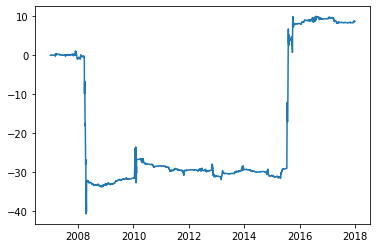

In [57]:
# Extreme short positions taken

plt.plot(max_diverse_cumulative_perf)
plt.show()

### Max Diversification (Long-only) Weighting

In [102]:
max_diverse_long_only_weights = get_max_diverse_long_only_weights(
    tickers        = universe_tickers,
    start_date     = dtime(2007, 1, 1),
    end_date       = dtime(2017, 12, 31),
    rebalance_days = 365 # Rebalance every year
)

max_diverse_long_only_daily_perf, max_diverse_long_only_cumulative_perf = \
    execute_strategy_v2(max_diverse_long_only_weights)

c:\users\luoje\appdata\local\programs\python\python36\lib\site-packages\cvxpy\problems\problem.py:1268: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


### Factor Model Weighting

In [212]:
def get_factor_analysis_weights(tickers, start_date, end_date, rebalance_days, num_factors: int = 6):
    date_range = pd.date_range(start_date, end_date)
    tickers    = list(set(universe_tickers).intersection(set(tickers)))
    ret_df     = pd.DataFrame(index = date_range, columns = tickers)
    fa_weight  = None
    
    filtered_pct_returns = pct_returns[tickers]
    
    for date in date_range:
        if (date - start_date).days % rebalance_days == 0:
            
            pca = PCA(n_components = num_factors)
            pca.fit(filtered_pct_returns[:date + tdelta(days=-1)])
#             print(filtered_pct_returns[:date].shape)

            # Each column vector / eigenvector is a factor loading
            eigenvecs         = pca.components_.T
            factor_loadings   = pca.components_.T

            # Apply dimensionality reduction
            factor_returns = pca.fit_transform(filtered_pct_returns[:date + tdelta(days=-1)])
            cov_factor     = np.cov(np.transpose(factor_returns))
            mu             = pca.mean_

            # Constructing the matrix D
            reconstructed_returns = factor_returns @ factor_loadings.T + mu.T
            unexplained_returns   = filtered_pct_returns[:date + tdelta(days=-1)] - reconstructed_returns
            unexplained_variance  = np.diag(np.cov(unexplained_returns.T))
            D                     = np.diag(unexplained_variance)

            w  = cp.Variable(len(filtered_pct_returns.columns)) # weight
            fw = cp.Variable(num_factors) # factor weight
            e  = np.ones(len(filtered_pct_returns.columns))

            target_risk = 0.0001
            
#             print(mu.shape, w.shape, fw.shape, cov_factor.shape, D.shape, factor_loadings.shape, e.shape)
#             print(factor_returns.shape)

            # Solve convex optimization problem 
            # =================================
            # Details here: https://www.mathworks.com/help/finance/portfolio-optimization-using-factor-models.html
            objective   = cp.Maximize(mu.T @ w)
            constraints = [
                cp.quad_form(fw, cov_factor) + cp.quad_form(w, D) <= target_risk,
                w.T @ e == 1,
                factor_loadings.T @ w == fw,
                w >= 0,
            ]

            prob = cp.Problem(objective, constraints)
            prob.solve()
            
            # Recalibrate weight on rebalance day
            fa_weight = w.value
        
        else: # No need to rebalance, just use previously calculated weights
            ret_df.loc[date] = fa_weight
            
    return ret_df.dropna()

In [213]:
fa_weights = get_factor_analysis_weights(
    tickers        = list(sp_500.ticker[:20]),
    start_date     = dtime(2007, 1, 1),
    end_date       = dtime(2017, 12, 31),
    rebalance_days = 90 # Rebalance every quarter
)

fa_daily_perf, fa_cumulative_perf = execute_strategy_v2(fa_weights)

(502, 6)
(563, 6)
(626, 6)
(688, 6)
(750, 6)
(810, 6)
(873, 6)
(935, 6)
(999, 6)
(1060, 6)
(1122, 6)
(1184, 6)
(1247, 6)
(1307, 6)
(1369, 6)
(1432, 6)
(1496, 6)
(1557, 6)
(1619, 6)
(1681, 6)
(1744, 6)
(1804, 6)
(1867, 6)
(1931, 6)
(1991, 6)
(2051, 6)
(2113, 6)
(2176, 6)
(2239, 6)
(2299, 6)
(2363, 6)
(2425, 6)
(2488, 6)
(2547, 6)
(2610, 6)
(2672, 6)
(2736, 6)
(2797, 6)
(2859, 6)
(2921, 6)
(2984, 6)
(3044, 6)
(3106, 6)
(3169, 6)
(3233, 6)


### Fama French

In [19]:
def get_fama_weights(tickers, start_date, end_date, rebalance_days):
    date_range = pd.date_range(start_date, end_date)
    tickers    = list(set(universe_tickers).intersection(set(tickers)))
    ret_df     = pd.DataFrame(index = date_range, columns = tickers)
    fa_weight  = None
    
    filtered_pct_returns = pct_returns[tickers]
    
    stock_prices_df_wide = stock_prices_df.pivot(index='date', columns='ticker', values='adj_close').loc[:, tickers]
    
    num_factors = 6
    
    df_ff = fama_french[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']] / 100
    df_ff = df_ff.resample('D').mean().ffill()
    df_ff.index = df_ff.index.astype('datetime64[ns]')
    df_ff = df_ff.loc[stock_prices_df_wide.index]
    df_ff['const'] = 1.0 # adds constant term
    
    for date in date_range:
        if (date - start_date).days % rebalance_days == 0:
            
            # lag the historical data to prevent lookahead
            curr_df_ff = df_ff[:date + tdelta(days=-1)]
            curr_stock_prices_df_wide = stock_prices_df_wide[:date + tdelta(days=-1)]
            curr_filtered_pct_returns = filtered_pct_returns[:date + tdelta(days=-1)]
            
    
            beta = pd.DataFrame()             # finds the factor exposures to 
            for sym in curr_stock_prices_df_wide.columns:
                model = sm.OLS(curr_stock_prices_df_wide[sym], curr_df_ff)
                results = model.fit()
                beta = pd.concat([beta, pd.DataFrame([results.params], index=[sym])])
            
            # invest in stocks with more than 2 positive exposures to the fama french
            w = (((beta.iloc[:, :5] > 0).sum(axis=1)) > 2)
            w *= (1 / w.sum())
        
        else: # No need to rebalance, just use previously calculated weights
            ret_df.loc[date] = w
            
    return ret_df#.dropna()

In [299]:
fama_weights = get_fama_weights(
    tickers        = list(sp_500.ticker[:100]),
    start_date     = dtime(2007, 1, 1),
    end_date       = dtime(2017, 12, 31),
    rebalance_days = 180 # Rebalance every quarter
)

fama_daily_perf, fama_cumulative_perf = execute_strategy_v2(fama_weights)

### Momentum

In [20]:
# stock_prices_df_wide = stock_prices_df.pivot(index='date', columns='ticker', values='adj_close').iloc[:,-105:]
stock_prices_df_wide = raw_prices

#### MACD

In [21]:
# shift 1 to prevent seeing future information

ema12 = stock_prices_df_wide.ewm(span=12, adjust=False).mean()
ema26 = stock_prices_df_wide.ewm(span=26, adjust=False).mean()
macd = ema12 - ema26
signal_line = macd.ewm(span=9, adjust=False).mean() - macd


In [22]:
# buy when signal line > 0, sell otherwise
macd_position = (signal_line > 0).rolling(5).max()

In [23]:
# stock_prices_df_wide.pct_change() * macd_position

In [24]:
# macd_position.mean(axis=0)

In [36]:
macd_daily_perf = (stock_prices_df_wide.pct_change() * macd_position.shift(1)).mean(axis=1).dropna()
macd_cumulative_perf = np.exp(macd_daily_perf.cumsum())

In [41]:
# macd_cumulative_perf.plot()

#### Stochastic optimizer

In [29]:
#Create the "L14" column in the DataFrame
stock_prices_df_wide_min = stock_prices_df_wide.rolling(window=14).min().shift(1)
#Create the "H14" column in the DataFrame
stock_prices_df_wide_max = stock_prices_df_wide.rolling(window=14).max().shift(1)
#Create the "%K" column in the DataFrame
stock_prices_df_wide_K = 100*((stock_prices_df_wide - stock_prices_df_wide_min) / (stock_prices_df_wide_max - stock_prices_df_wide_min) )
#Create the "%D" column in the DataFrame
stock_prices_df_wide_D = stock_prices_df_wide_K.rolling(window=3).mean()

In [30]:
#Create a column in the DataFrame showing "TRUE" if sell entry signal is given and "FALSE" otherwise. 
#A sell is initiated when the %K line crosses down through the %D line and the value of the oscillator is above 80 
# df['Sell Entry'] = ((df['%K'] < df['%D']) & (df['%K'].shift(1) > df['%D'].shift(1))) & (df['%D'] > 80) 
stock_prices_df_wide_sell_entry = (stock_prices_df_wide_K < stock_prices_df_wide_D) \
    & (stock_prices_df_wide_K.shift(1) > stock_prices_df_wide_D.shift(1)) & (stock_prices_df_wide_D > 80) 

#Create a column in the DataFrame showing "TRUE" if sell exit signal is given and "FALSE" otherwise. 
#A sell exit signal is given when the %K line crosses back up through the %D line 
# df['Sell Exit'] = ((df['%K'] > df['%D']) & (df['%K'].shift(1) < df['%D'].shift(1))) 
stock_prices_df_wide_sell_exit = ((stock_prices_df_wide_K > stock_prices_df_wide_D) &\
                                  (stock_prices_df_wide_K.shift(1) < stock_prices_df_wide_D.shift(1))) 

#create a placeholder column to populate with short positions (-1 for short and 0 for flat) using boolean values created above 
stock_prices_df_wide_short = pd.DataFrame().reindex_like(stock_prices_df_wide_sell_exit)
stock_prices_df_wide_short = stock_prices_df_wide_short.where(stock_prices_df_wide_sell_entry, -1)
stock_prices_df_wide_short = stock_prices_df_wide_short.where(stock_prices_df_wide_sell_exit, 0)

# #Set initial position on day 1 to flat 
# df['Short'][0] = 0 
stock_prices_df_wide_short.iloc[0] = 0

# #Forward fill the position column to represent the holding of positions through time 
# df['Short'] = df['Short'].fillna(method='pad') 
stock_prices_df_wide_short.fillna(method='pad')

#Create a column in the DataFrame showing "TRUE" if buy entry signal is given and "FALSE" otherwise. 
#A buy is initiated when the %K line crosses up through the %D line and the value of the oscillator is below 20 
stock_prices_df_wide_buy_entry = ((stock_prices_df_wide_K > stock_prices_df_wide_D) &\
                   (stock_prices_df_wide_K.shift(1) < stock_prices_df_wide_D.shift(1))) &\
                    (stock_prices_df_wide_D < 20) 

#Create a column in the DataFrame showing "TRUE" if buy exit signal is given and "FALSE" otherwise. 
#A buy exit signal is given when the %K line crosses back down through the %D line 
stock_prices_df_wide_buy_exit = ((stock_prices_df_wide_K < stock_prices_df_wide_D) &\
                  (stock_prices_df_wide_K.shift(1) > stock_prices_df_wide_D.shift(1))) 

# #create a placeholder column to polulate with long positions (1 for long and 0 for flat) using boolean values created above 
# df['Long'] = np.nan  
# df.loc[df['Buy Entry'],'Long'] = 1  
# df.loc[df['Buy Exit'],'Long'] = 0  
stock_prices_df_wide_long = pd.DataFrame().reindex_like(stock_prices_df_wide_buy_exit)
stock_prices_df_wide_long = stock_prices_df_wide_long.where(stock_prices_df_wide_buy_entry, 1)
stock_prices_df_wide_long = stock_prices_df_wide_long.where(stock_prices_df_wide_buy_exit, 0)

# #Set initial position on day 1 to flat 
# df['Long'][0] = 0  
stock_prices_df_wide_long.iloc[0] = 0

# #Forward fill the position column to represent the holding of positions through time 
# df['Long'] = df['Long'].fillna(method='pad') 
stock_prices_df_wide_long.fillna(method='pad')

# #Add Long and Short positions together to get final strategy position (1 for long, -1 for short and 0 for flat) 
# df['Position'] = df['Long'] + df['Short']
final_position = stock_prices_df_wide_long + stock_prices_df_wide_short
# final_position = final_position.astype(int)

In [31]:
stochastic_osc_daily_perf = stock_prices_df_wide.pct_change() * final_position.shift(1)
stochastic_osc_cumulative_perf = np.exp(stochastic_osc_daily_perf.cumsum().mean(axis=1))

In [32]:
# final_position_adj = (final_position - (final_position.sum(axis=1).min() - 1) / final_position.shape[1]).astype(float)
# final_position_adj = final_position_adj.div(final_position_adj.sum(axis=1), axis=0)
# final_position_adj = final_position_adj.shift(1)

In [33]:
# stochastic_osc_weights = pd.read_csv('temp.csv', index_col=0)
# stochastic_osc_weights.index = pd.to_datetime(stochastic_osc_weights.index)
# # stochastic_osc_weights = stochastic_osc_weights.loc[pd.datetime(2007,1,1):] 
# stochastic_osc_daily_perf, stochastic_osc_cumulative_perf = \
#     execute_strategy_v2(stochastic_osc_weights)

#### Combining both MACD and stochastic

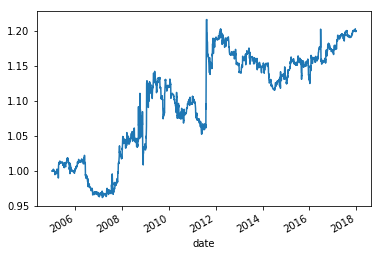

In [34]:
combined_strategy = (macd_position * final_position.shift(1)) * stock_prices_df_wide.pct_change()
np.exp(combined_strategy.cumsum().mean(axis=1)).plot()

### Visualization

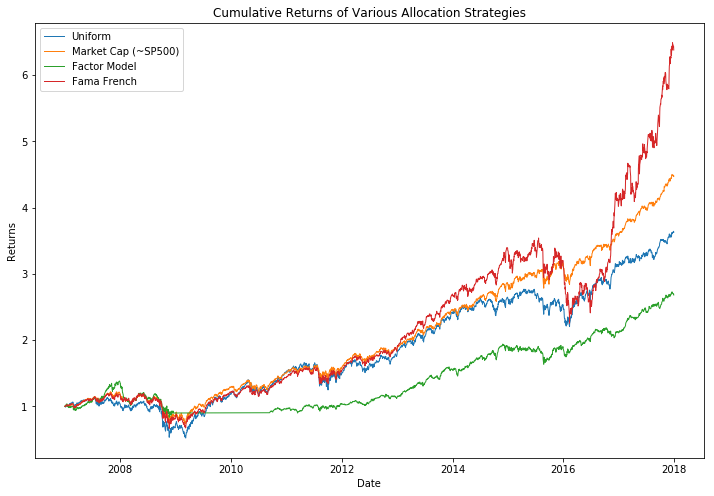

In [300]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(unif_cumulative_perf,                  linewidth=1.0, label="Uniform")
ax.plot(sp500_cumulative_perf,                 linewidth=1.0, label="Market Cap (~SP500)")
# ax.plot(max_diverse_cumulative_perf,           linewidth=1.0, label="Max Diversification")
# ax.plot(max_diverse_long_only_cumulative_perf, linewidth=1.0, label="Max Diversification (Long-only, Yearly Rebalancing)")
# ax.plot(stochastic_osc_cumulative_perf,             linewidth=1.0, label="Stochastic")
# ax.plot(macd_cumulative_perf,             linewidth=1.0, label="MACD")
ax.plot(fa_cumulative_perf,                    linewidth=1.0, label="Factor Model")
ax.plot(fama_cumulative_perf,                    linewidth=1.0, label="Fama French")
ax.set_title("Cumulative Returns of Various Allocation Strategies")
ax.set_xlabel("Date")
ax.set_ylabel("Returns")
ax.legend()
plt.show()

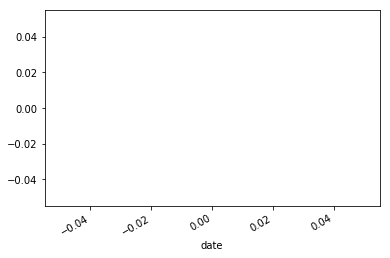

In [192]:
fama_cumulative_perf.plot()

### Statistical Factor Model (In-progress)

In [89]:
pca = PCA(n_components = 5)

pca.fit(pct_returns)

# Each column vector / eigenvector is a factor loading
eigenvecs = np.transpose(pca.components_)

In [77]:
pca.explained_variance_

array([0.40523182, 0.03910722, 0.02827506, 0.02468892, 0.01980486])

In [97]:
estimated_factors = eigenvecs.T @ pct_returns.iloc[3].values

In [98]:
estimated_factors

array([ 0.2593604 , -0.0715072 ,  0.24740362,  0.03167702,  0.0723495 ])

At a specific time $t$ for which the portfolio is to be rebalanced, for each asset $k$, we try to find the asset's exposure to each factor via OLS:

$
R_k(t) = \alpha_k + \sum_i^{n} \beta_{ki} f_i(t) = \alpha_k + \beta_{k1} f_1 + \beta_{k2} f_2 + ... + \beta_{kn} f_n
$

We will estimate the coefficients $\beta_{ki} \forall i$ for a given asset $k$.

In [87]:
pct_returns.shape

(3271, 1926)

In [85]:
# Apply dimension reduction

factor_returns = pca.fit_transform(pct_returns)

In [86]:
factor_returns.shape

(3271, 5)